# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import xgboost as xgb

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
# using SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [9]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [10]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [11]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [14]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [15]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [18]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [19]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [21]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [22]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [25]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [26]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [28]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:32<00:00, 2664.06it/s]


In [29]:
preprocessed_reviews[87772]

'purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Summary'].value_counts()

(160176, 10)


Delicious!                                                                744
Delicious                                                                 710
Yummy!                                                                    483
Yummy                                                                     380
Great product                                                             340
Yum!                                                                      339
Excellent                                                                 317
Great Product                                                             290
Love it!                                                                  285
Great                                                                     239
Great!                                                                    229
Tasty                                                                     183
Yum                                                             

In [0]:
# printing some random reviews
summary_0 = final['Summary'].values[0]
print(summary_0)
print("="*50)

summary_1000 = final['Summary'].values[1000]
print(summary_1000)
print("="*50)

summary_1500 = final['Summary'].values[1500]
print(summary_1500)
print("="*50)

summary_4900 = final['Summary'].values[4900]
print(summary_4900)
print("="*50)

A classic
Diamond dog food
Essential for Tonkatsu, etc
Better to the last drop


In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
summary_0 = re.sub(r"http\S+", "", summary_0)
summary_1000 = re.sub(r"http\S+", "", summary_1000)
summary_150 = re.sub(r"http\S+", "", summary_1500)
summary_4900 = re.sub(r"http\S+", "", summary_4900)

print(summary_0)

A classic


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(summary_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(summary_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(summary_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(summary_4900, 'lxml')
text = soup.get_text()
print(text)

A classic
Diamond dog food
Essential for Tonkatsu, etc
Better to the last drop


In [0]:
summary_1500 = decontracted(summary_1500)
print(summary_1500)
print("="*50)

Essential for Tonkatsu, etc


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
summary_0 = re.sub("\S*\d\S*", "", summary_0).strip()
print(summary_0)

A classic


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
summary_1500 = re.sub('[^A-Za-z0-9]+', ' ', summary_1500)
print(summary_1500)

Essential for Tonkatsu etc


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

 58%|█████▊    | 92203/160176 [00:21<00:14, 4571.66it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 160176/160176 [00:36<00:00, 4391.77it/s]


#### Train-Test Split

In [0]:
X=preprocessed_reviews[:]
y=final['Score'][:]

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)

- - - 

# [4] Featurization

## [4.1] BAG OF WORDS

In [32]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 46115)
the number of unique words  46115


## [4.2] Bi-Grams and n-Grams.

In [81]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 5000)
the number of unique words including both unigrams and bigrams  5000


In [0]:
X_test1 =  count_vect.transform(X_test)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


grid_params = dict(n_estimators = [10,20,30,50,100],
                   max_depth= [3,6,10,15,20] )

rf = RandomForestClassifier()
rf_clf = GridSearchCV(rf, param_grid=grid_params, n_jobs=-1, verbose=30,return_train_score=True,scoring='roc_auc')
rf_clf = rf_clf.fit(final_bigram_counts, y_train)


results = rf_clf.cv_results_


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

In [38]:
print("Best parameters: ", rf_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(rf_clf.best_score_))

Best parameters:  {'max_depth': 20, 'n_estimators': 100}
Best cross-validation score: 0.891


In [0]:
pred = rf_clf.predict(X_test1)
pred_train = rf_clf.predict(final_bigram_counts)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

train_error=rf_clf.cv_results_['mean_train_score']
cv_error = rf_clf.cv_results_['mean_test_score']
score=roc_auc_score(y_train, pred_train)

estimator=rf_clf.best_params_['n_estimators']
depth=rf_clf.best_params_['max_depth']


#### Error plots

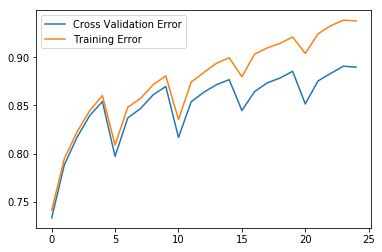

In [0]:
plt.plot(cv_error, label='Cross Validation Error')
plt.plot(train_error, label='Training Error')
plt.legend()
plt.show()

In [0]:

n_estimators =[10,20,30,50,100]
max_depth= [3,6,10,15,20] 

### HeatMap for AUC vs N_estimators and Max_Depth

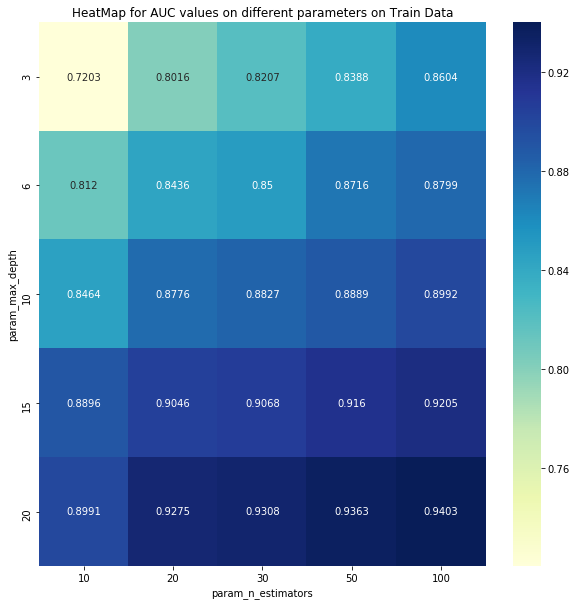

In [40]:
df_new = pd.DataFrame(rf_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_train_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Train Data')
plt.show()

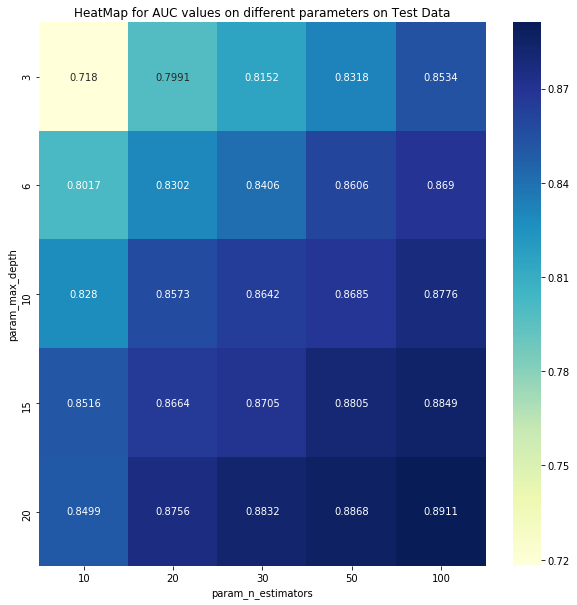

In [41]:
df_new = pd.DataFrame(rf_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_test_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Test Data')
plt.show()

In [0]:
pred_test = rf_clf.predict_proba(X_test1)[:,1]
pred_train =  rf_clf.predict_proba(final_bigram_counts)[:,1]

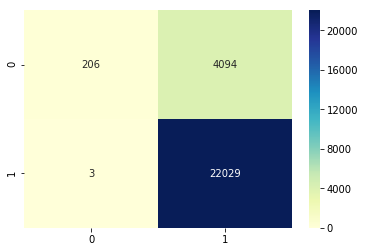

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_test.round())
sns.heatmap(cm, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
fpr2, tpr2, thresholds = roc_curve(y_train, pred_train)

score_test = roc_auc_score(y_test, pred_test)
score_train = roc_auc_score(y_train, pred_train)

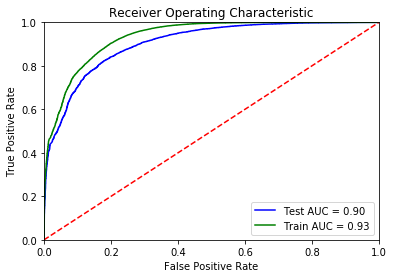

In [0]:
roc_auc_test = metrics.auc(fpr, tpr)
roc_auc_train = metrics.auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='Test AUC = %0.2f' % score_test)
plt.plot(fpr2, tpr2, 'g', label = 'Train AUC = %0.2f' % score_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Wordcloud Top-20 Features

In [0]:
model = RandomForestClassifier(n_estimators= 100 , max_depth=20, class_weight='balanced')
model.fit(final_bigram_counts, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

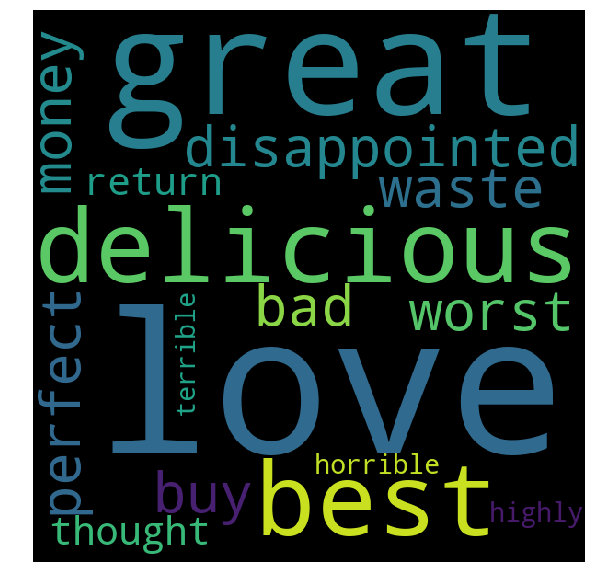

In [0]:

# Please write all the code with proper documentation
# Copied from wordcloud documentation
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
from wordcloud import WordCloud, STOPWORDS

feat_imp = model.feature_importances_

count_features=count_vect.get_feature_names()
feature_importances = pd.DataFrame(feat_imp,index = count_features, columns=['importance']).sort_values('importance',ascending=False)

a = feature_importances.iloc[0:20]
comment_words = ' '
for val in a.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='Black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


- - -

### Applying XGBOOST Classifier

In [42]:
from sklearn.model_selection import GridSearchCV


grid_params = {'n_estimators': [5, 10, 15,20,50,100],
              'max_depth': [2, 5,10, 15]}

xg_clf = xgb.XGBClassifier()
xg_clf = GridSearchCV(xg_clf, param_grid=grid_params, n_jobs=-1, verbose=30,return_train_score=True,scoring='roc_auc')
xg_clf = xg_clf.fit(final_bigram_counts, y_train)

results =xg_clf.cv_results_


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

In [43]:
print("Best parameters: ", xg_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(xg_clf.best_score_))

Best parameters:  {'max_depth': 15, 'n_estimators': 100}
Best cross-validation score: 0.930


In [0]:
pred_test = xg_clf.predict(X_test1)
pred_train = xg_clf.predict(final_bigram_counts)

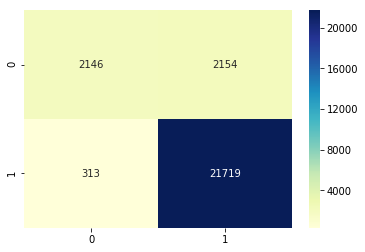

In [0]:
cm = confusion_matrix(y_test, pred_test.round())
sns.heatmap(cm, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

train_error=xg_clf.cv_results_['mean_train_score']
cv_error = xg_clf.cv_results_['mean_test_score']
score=roc_auc_score(y_train, pred_train)

estimator=xg_clf.best_params_['n_estimators']
depth=xg_clf.best_params_['max_depth']


#### Error Plots

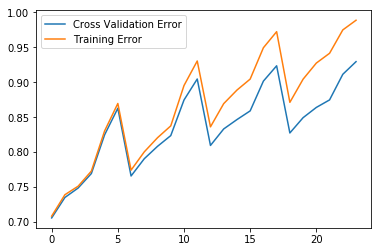

In [0]:
plt.plot(cv_error, label='Cross Validation Error')
plt.plot(train_error, label='Training Error')
plt.legend()
plt.show()

In [0]:
n_estimators =[5, 10, 15,20,50,100]
max_depth= [2, 5,10, 15] 

### HeatMap for AUC vs N_estimators and Max_Depth

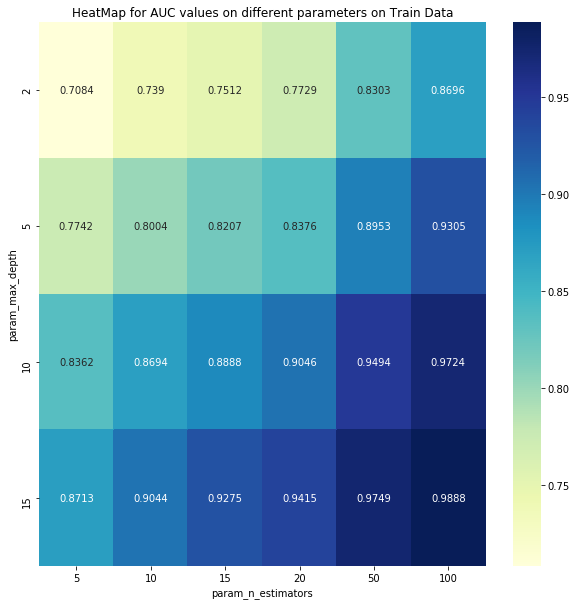

In [44]:
df_new = pd.DataFrame(xg_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_train_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Train Data')
plt.show()

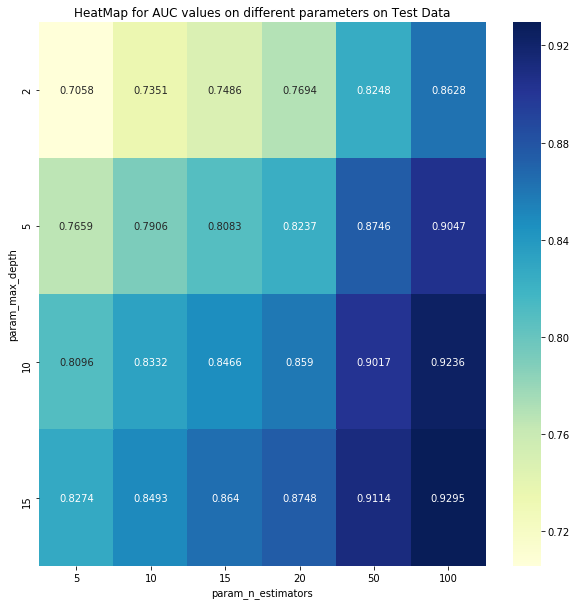

In [45]:
df_new = pd.DataFrame(xg_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_test_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Test Data')
plt.show()

In [0]:
pred_test = xg_clf.predict_proba(X_test1)[:,1]
pred_train =  xg_clf.predict_proba(final_bigram_counts)[:,1]

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
fpr2, tpr2, thresholds = roc_curve(y_train, pred_train)

score_test = roc_auc_score(y_test, pred_test)
score_train = roc_auc_score(y_train, pred_train)

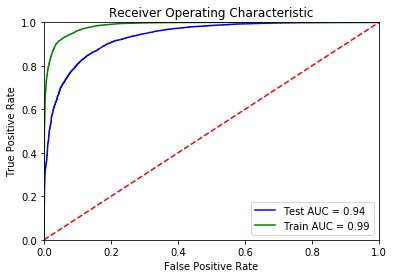

In [0]:
roc_auc_test = metrics.auc(fpr, tpr)
roc_auc_train = metrics.auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='Test AUC = %0.2f' % score_test)
plt.plot(fpr2, tpr2, 'g', label = 'Train AUC = %0.2f' % score_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Wordcloud for Top-20 Features

In [0]:
model = xgb.XGBClassifier(n_estimators= 100 , max_depth=15, class_weight='balanced')
model.fit(final_bigram_counts, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

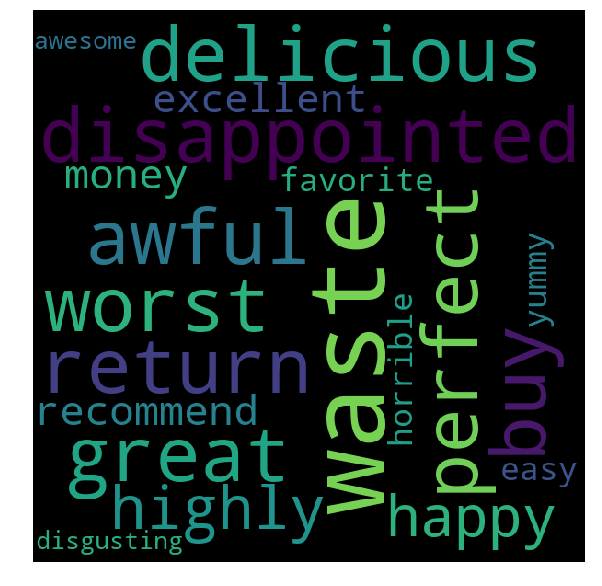

In [0]:

# Please write all the code with proper documentation
# Copied from wordcloud documentation
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
from wordcloud import WordCloud, STOPWORDS

feat_imp = model.feature_importances_

count_features=count_vect.get_feature_names()
feature_importances = pd.DataFrame(feat_imp,index = count_features, columns=['importance']).sort_values('importance',ascending=False)

a = feature_importances.iloc[0:20]
comment_words = ' '
for val in a.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='Black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


- - -

## [4.3] TF-IDF

In [179]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink', 'able eat']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36458)
the number of unique words including both unigrams and bigrams  36458


In [0]:
X_test2 =  tf_idf_vect.transform(X_test)

### Applying Random Forest Classifier

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit



grid_params = dict(n_estimators = [10,20,30,50,100],
                   max_depth= [3,6,10,15,20] )


rf = RandomForestClassifier()
rf_clf = GridSearchCV(rf, param_grid=grid_params, n_jobs=-1, verbose=30,return_train_score=True,scoring='roc_auc')
rf_clf = rf_clf.fit(final_tf_idf, y_train)


results = rf_clf.cv_results_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

In [49]:
print("Best parameters: ", rf_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(rf_clf.best_score_))

Best parameters:  {'max_depth': 20, 'n_estimators': 100}
Best cross-validation score: 0.907


In [0]:
pred = rf_clf.predict(X_test2)
pred_train = rf_clf.predict(final_tf_idf)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

train_error=rf_clf.cv_results_['mean_train_score']
cv_error = rf_clf.cv_results_['mean_test_score']
score=roc_auc_score(y_train, pred_train)

estimator=rf_clf.best_params_['n_estimators']
depth=rf_clf.best_params_['max_depth']


#### Error Plots

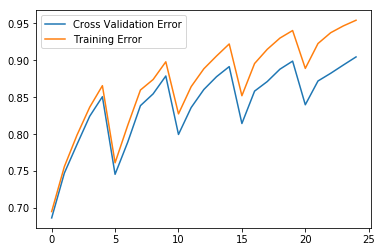

In [0]:
plt.plot(cv_error, label='Cross Validation Error')
plt.plot(train_error, label='Training Error')
plt.legend()
plt.show()

In [0]:
n_estimators =[10,20,30,50,100]
max_depth= [3,6,10,15,20] 


### HeatMap for AUC vs N_estimators and Max_Depth

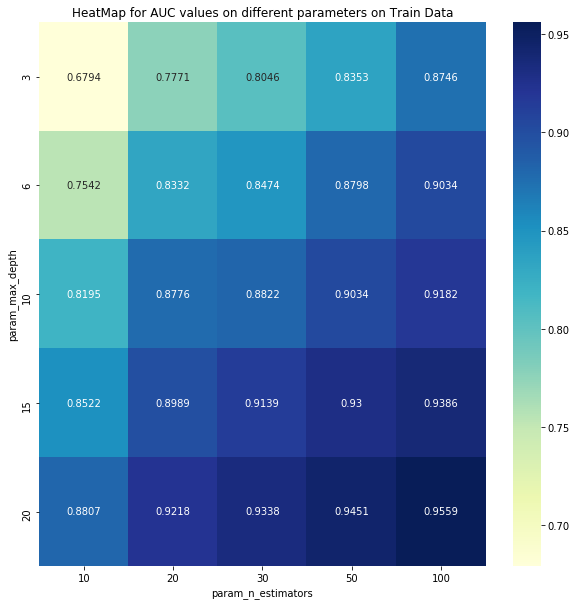

In [50]:
df_new = pd.DataFrame(rf_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_train_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Train Data')
plt.show()

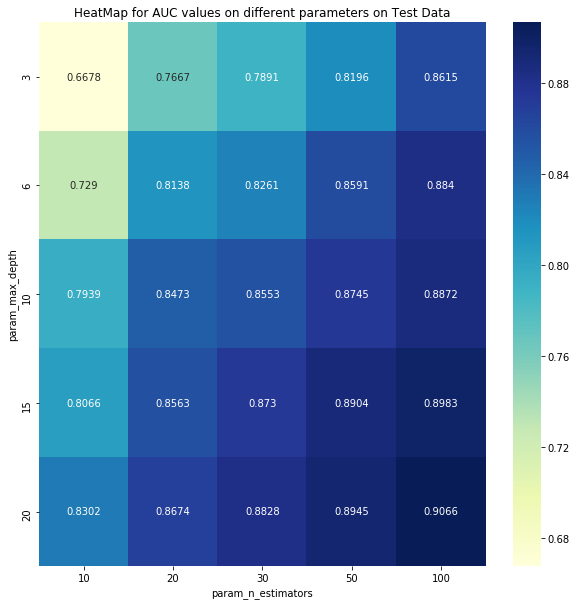

In [51]:
df_new = pd.DataFrame(rf_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_test_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Test Data')
plt.show()

In [0]:
pred_test = rf_clf.predict_proba(X_test2)[:,1]
pred_train =  rf_clf.predict_proba(final_tf_idf)[:,1]

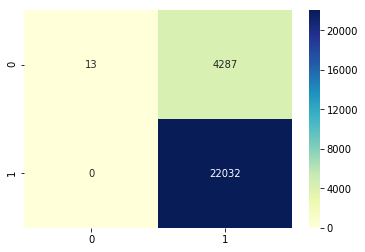

In [0]:

cm = confusion_matrix(y_test, pred_test.round())
sns.heatmap(cm, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
fpr2, tpr2, thresholds = roc_curve(y_train, pred_train)

score_test = roc_auc_score(y_test, pred_test)
score_train = roc_auc_score(y_train, pred_train)

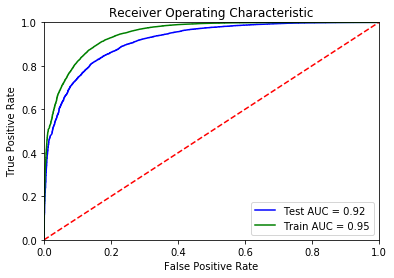

In [0]:
roc_auc_test = metrics.auc(fpr, tpr)
roc_auc_train = metrics.auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='Test AUC = %0.2f' % score_test)
plt.plot(fpr2, tpr2, 'g', label = 'Train AUC = %0.2f' % score_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [0]:
model = RandomForestClassifier(n_estimators= 100 , max_depth=20, class_weight='balanced')
model.fit(final_tf_idf, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

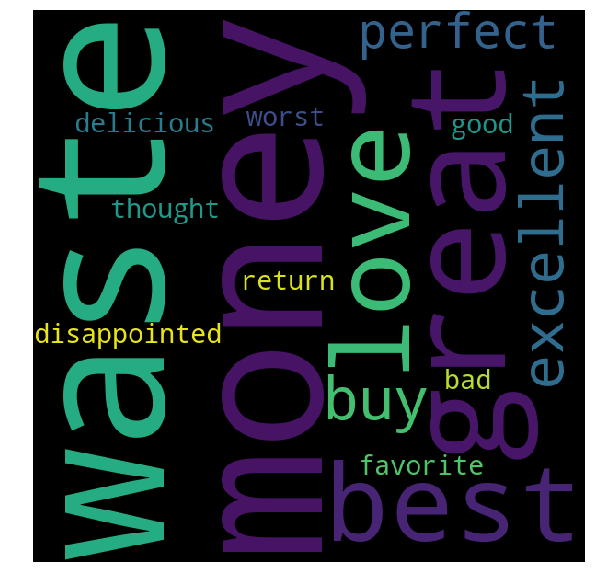

In [0]:

# Please write all the code with proper documentation
# Copied from wordcloud documentation
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
from wordcloud import WordCloud, STOPWORDS

feat_imp = model.feature_importances_

count_features=tf_idf_vect.get_feature_names()
feature_importances = pd.DataFrame(feat_imp,index = count_features, columns=['importance']).sort_values('importance',ascending=False)

a = feature_importances.iloc[0:20]
comment_words = ' '
for val in a.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='Black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


### Applying XGBOOST Classifier

In [52]:
from sklearn.model_selection import GridSearchCV


grid_params = {'n_estimators': [5, 10, 15,20,50,100],
              'max_depth': [2, 5,10, 15]}

xg_clf = xgb.XGBClassifier()
xg_clf = GridSearchCV(xg_clf, param_grid=grid_params, n_jobs=-1, verbose=30,return_train_score=True,scoring='roc_auc')
xg_clf = xg_clf.fit(final_tf_idf, y_train)

results =xg_clf.cv_results_


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.6s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 

In [53]:
print("Best parameters: ", xg_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(xg_clf.best_score_))

Best parameters:  {'max_depth': 15, 'n_estimators': 100}
Best cross-validation score: 0.929


In [0]:
pred = xg_clf.predict(X_test2)
pred_train = xg_clf.predict(final_tf_idf)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

train_error=xg_clf.cv_results_['mean_train_score']
cv_error = xg_clf.cv_results_['mean_test_score']
score=roc_auc_score(y_train, pred_train)

estimator=xg_clf.best_params_['n_estimators']
depth=xg_clf.best_params_['max_depth']


#### Error plots

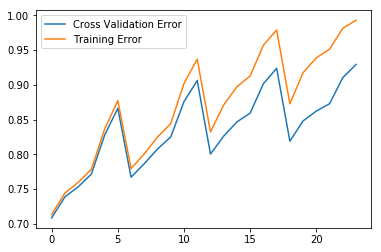

In [0]:
plt.plot(cv_error, label='Cross Validation Error')
plt.plot(train_error, label='Training Error')
plt.legend()
plt.show()

In [0]:
n_estimators =[5, 10, 15,20,50,100]
max_depth= [2, 5,10, 15] 

### HeatMap for AUC vs N_estimators and Max_Depth

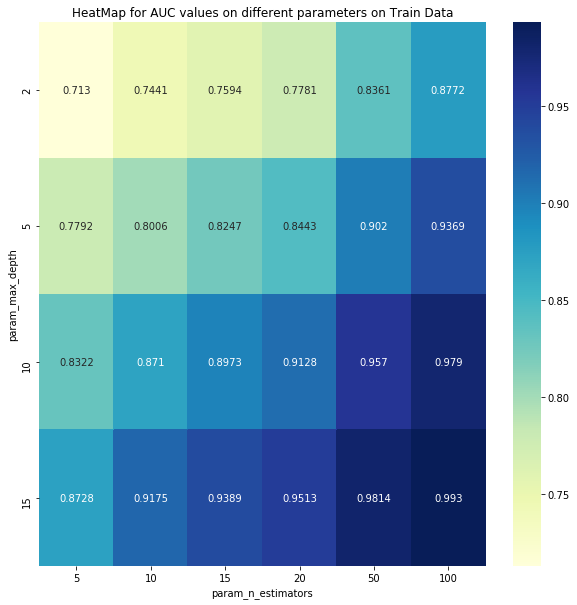

In [54]:
df_new = pd.DataFrame(xg_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_train_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Train Data')
plt.show()

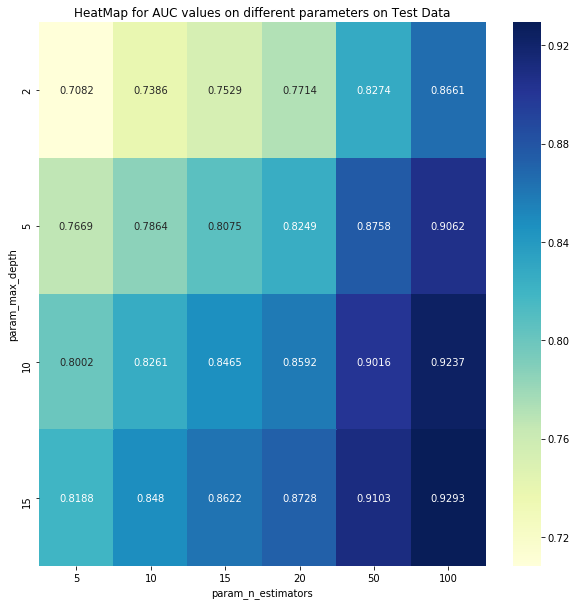

In [55]:
df_new = pd.DataFrame(xg_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_test_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Test Data')
plt.show()

In [0]:
pred_test = xg_clf.predict_proba(X_test2)[:,1]
pred_train =  xg_clf.predict_proba(final_tf_idf)[:,1]

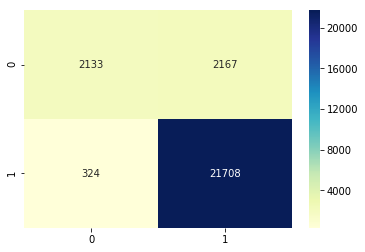

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_test.round())
sns.heatmap(cm, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
fpr2, tpr2, thresholds = roc_curve(y_train, pred_train)

score_test = roc_auc_score(y_test, pred_test)
score_train = roc_auc_score(y_train, pred_train)

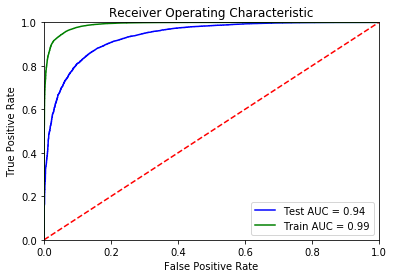

In [0]:
roc_auc_test = metrics.auc(fpr, tpr)
roc_auc_train = metrics.auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='Test AUC = %0.2f' % score_test)
plt.plot(fpr2, tpr2, 'g', label = 'Train AUC = %0.2f' % score_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Wordcloud for Tf-idf  Representation

In [0]:
model = xgb.XGBClassifier(n_estimators= 100 , max_depth=15, class_weight='balanced')
model.fit(final_tf_idf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

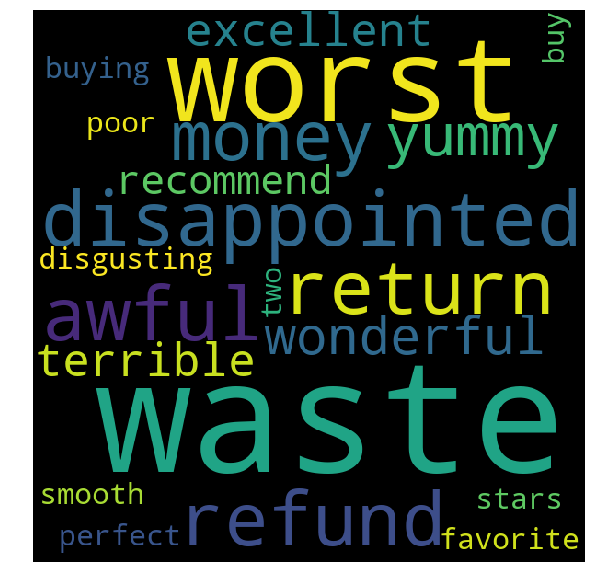

In [0]:

# Please write all the code with proper documentation
# Copied from wordcloud documentation
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
from wordcloud import WordCloud, STOPWORDS

feat_imp = model.feature_importances_

count_features = tf_idf_vect.get_feature_names()
feature_importances = pd.DataFrame(feat_imp,index = count_features, columns=['importance']).sort_values('importance',ascending=False)

a = feature_importances.iloc[0:20]
comment_words = ' '
for val in a.index: 
    val = str(val) 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

        stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='Black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


- - -

## [4.4] Word2Vec

In [0]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [141]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8344917893409729), ('good', 0.808018147945404), ('excellent', 0.8078727126121521), ('awesome', 0.8056349754333496), ('terrific', 0.7792290449142456), ('wonderful', 0.7600680589675903), ('perfect', 0.7576707601547241), ('nice', 0.7277341485023499), ('amazing', 0.7153280377388), ('decent', 0.6896257400512695)]
[('greatest', 0.8235164880752563), ('best', 0.718223512172699), ('tastiest', 0.7065260410308838), ('nastiest', 0.6868261098861694), ('disgusting', 0.6409940719604492), ('cry', 0.6292953491210938), ('horrible', 0.6168406009674072), ('closest', 0.6152921915054321), ('smoothest', 0.6110377907752991), ('surpass', 0.6036611199378967)]


In [144]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


In [0]:
X = list_of_sentance[:]
y = final['Score'][:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [150]:
# Then vectorize your train model as
train_sent = [];
for sent in tqdm(X_train):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent.append(sent_vec)




  0%|          | 0/61441 [00:00<?, ?it/s]

  0%|          | 43/61441 [00:00<02:23, 428.87it/s]

  0%|          | 75/61441 [00:00<02:44, 373.84it/s]

  0%|          | 114/61441 [00:00<02:43, 376.08it/s]

  0%|          | 153/61441 [00:00<02:42, 377.64it/s]

  0%|          | 190/61441 [00:00<02:45, 370.42it/s]

  0%|          | 238/61441 [00:00<02:34, 395.81it/s]

  0%|          | 274/61441 [00:00<02:41, 378.13it/s]

  1%|          | 313/61441 [00:00<02:40, 380.26it/s]

  1%|          | 362/61441 [00:00<02:30, 407.00it/s]

  1%|          | 413/61441 [00:01<02:27, 413.77it/s]

  1%|          | 471/61441 [00:01<02:14, 452.64it/s]

  1%|          | 521/61441 [00:01<02:10, 465.81it/s]

  1%|          | 575/61441 [00:01<02:06, 479.65it/s]

  1%|          | 624/61441 [00:01<02:21, 431.04it/s]

  1%|          | 673/61441 [00:01<02:17, 441.88it/s]

  1%|          | 721/61441 [00:01<02:15, 448.29it/s]

  1%|          | 768/61441 [00:01<02:13, 454.04it/s]

  1%|▏         | 819/61441 [00:01<02:10

In [151]:
test_sent = [];
for sent in tqdm(X_test):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent: #
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent.append(sent_vec)



  0%|          | 0/26332 [00:00<?, ?it/s]

  0%|          | 53/26332 [00:00<00:49, 525.84it/s]

  0%|          | 108/26332 [00:00<00:49, 532.21it/s]

  1%|          | 159/26332 [00:00<00:49, 524.03it/s]

  1%|          | 203/26332 [00:00<00:53, 491.95it/s]

  1%|          | 240/26332 [00:00<01:03, 410.86it/s]

  1%|          | 283/26332 [00:00<01:02, 414.07it/s]

  1%|▏         | 331/26332 [00:00<01:00, 431.10it/s]

  1%|▏         | 387/26332 [00:00<00:56, 457.56it/s]

  2%|▏         | 441/26332 [00:00<00:54, 476.97it/s]

  2%|▏         | 488/26332 [00:01<00:54, 474.77it/s]

  2%|▏         | 539/26332 [00:01<00:53, 484.63it/s]

  2%|▏         | 588/26332 [00:01<00:53, 477.34it/s]

  2%|▏         | 637/26332 [00:01<00:53, 479.72it/s]

  3%|▎         | 685/26332 [00:01<00:55, 466.06it/s]

  3%|▎         | 732/26332 [00:01<00:55, 460.31it/s]

  3%|▎         | 779/26332 [00:01<00:56, 453.32it/s]

  3%|▎         | 831/26332 [00:01<00:54, 471.28it/s]

  3%|▎         | 894/26332 [00:01<00:5

In [0]:
X_train3 = train_sent
X_test3 = test_sent

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

##  [4.4.1.1] Avg W2v

### Applying RandomForest Classifier

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


grid_params = dict(n_estimators = [2,5,20,50,75,100],
                   max_depth= [2,4,5,8,10] )

rf = RandomForestClassifier()
rf_clf = GridSearchCV(rf, param_grid=grid_params, n_jobs=-1, verbose=30,return_train_score=True,scoring='roc_auc',refit=True, cv=3)
rf_clf = rf_clf.fit(X_train3, y_train)


results = rf_clf.cv_results_


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

In [154]:
print("Best parameters: ", rf_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(rf_clf.best_score_))

Best parameters:  {'max_depth': 10, 'n_estimators': 100}
Best cross-validation score: 0.897


In [0]:
pred = rf_clf.predict(X_test3)
pred_train = rf_clf.predict(X_train3)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

train_error=rf_clf.cv_results_['mean_train_score']
cv_error = rf_clf.cv_results_['mean_test_score']
score=roc_auc_score(y_train, pred_train)

estimator=rf_clf.best_params_['n_estimators']
depth=rf_clf.best_params_['max_depth']


#### Error plots

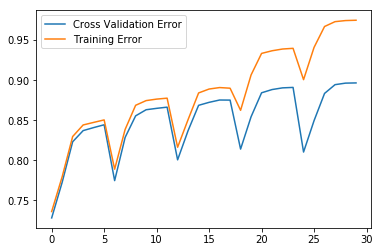

In [157]:
plt.plot(cv_error, label='Cross Validation Error')
plt.plot(train_error, label='Training Error')
plt.legend()
plt.show()

### HeatMap for AUC vs N_estimators and Max_Depth

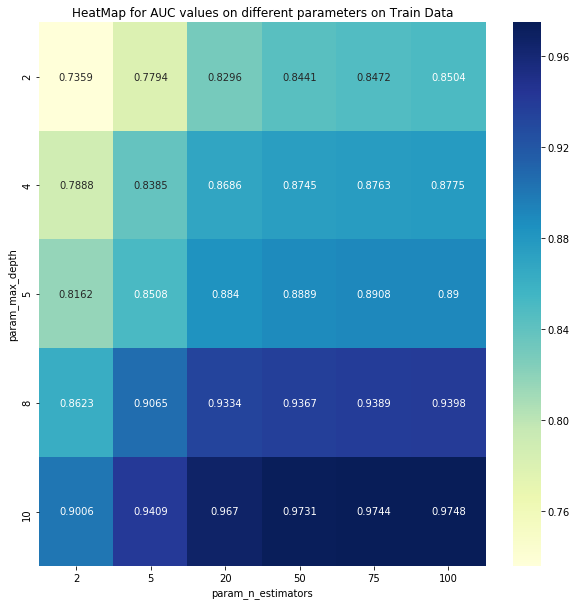

In [159]:
df_new = pd.DataFrame(rf_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_train_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Train Data')
plt.show()

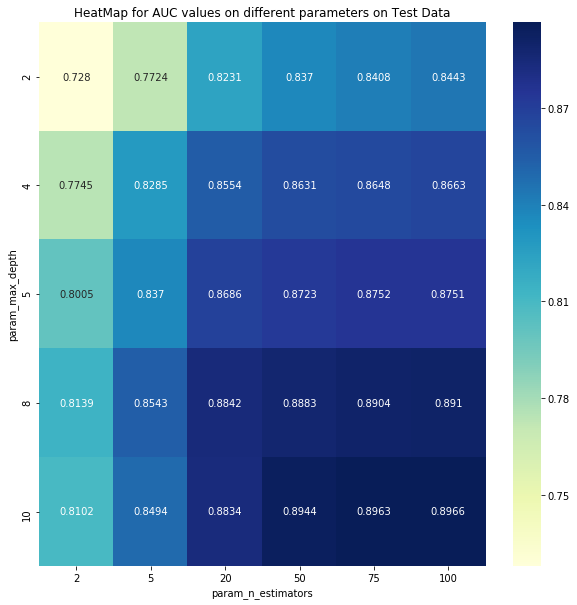

In [160]:
df_new = pd.DataFrame(rf_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_test_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Test Data')
plt.show()

In [0]:
pred_test = rf_clf.predict_proba(X_test3)[:,1]
pred_train =  rf_clf.predict_proba(X_train3)[:,1]

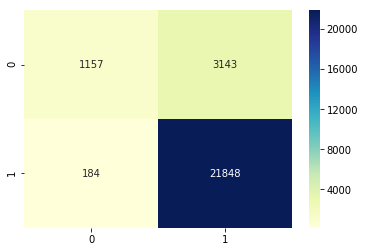

In [162]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_test.round())
sns.heatmap(cm, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
fpr2, tpr2, thresholds = roc_curve(y_train, pred_train)

score_test = roc_auc_score(y_test, pred_test)
score_train = roc_auc_score(y_train, pred_train)

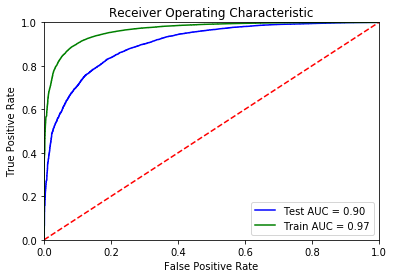

In [164]:
roc_auc_test = metrics.auc(fpr, tpr)
roc_auc_train = metrics.auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='Test AUC = %0.2f' % score_test)
plt.plot(fpr2, tpr2, 'g', label = 'Train AUC = %0.2f' % score_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Applying XGBOOST Classifier

In [166]:
from sklearn.model_selection import GridSearchCV

grid_params = {'n_estimators': [5, 10, 15,20],
              'max_depth': [2, 5, 15,25,50]}

xg_clf = xgb.XGBClassifier()
xg_clf = GridSearchCV(xg_clf, param_grid=grid_params, n_jobs=-1, verbose=30,return_train_score=True,scoring='roc_auc')
xg_clf = xg_clf.fit(np.array(X_train3), y_train)

results =xg_clf.cv_results_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   14.0s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout o

In [167]:
print("Best parameters: ", xg_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(xg_clf.best_score_))

Best parameters:  {'max_depth': 15, 'n_estimators': 20}
Best cross-validation score: 0.886


In [0]:
pred = xg_clf.predict(X_test3)
pred_train = xg_clf.predict(X_train3)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

train_error=xg_clf.cv_results_['mean_train_score']
cv_error = xg_clf.cv_results_['mean_test_score']
score=roc_auc_score(y_train, pred_train)

estimator=xg_clf.best_params_['n_estimators']
depth=xg_clf.best_params_['max_depth']


#### Error Plots

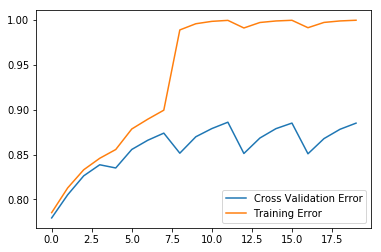

In [170]:
plt.plot(cv_error, label='Cross Validation Error')
plt.plot(train_error, label='Training Error')
plt.legend()
plt.show()

### HeatMap for AUC vs N_estimators and Max_Depth

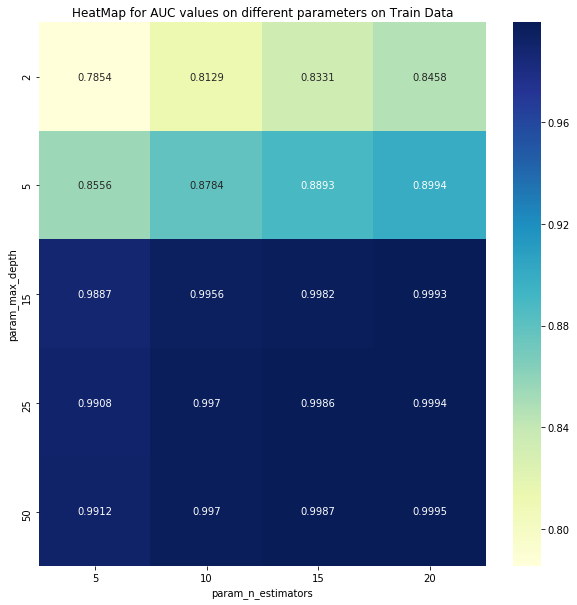

In [171]:
df_new = pd.DataFrame(xg_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_train_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Train Data')
plt.show()

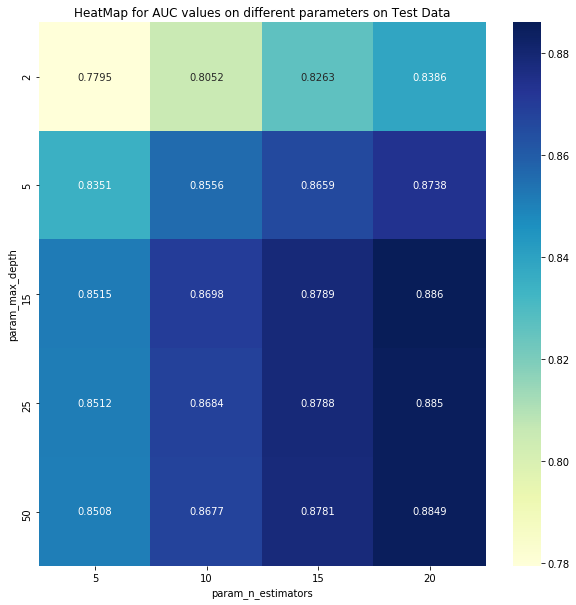

In [172]:
df_new = pd.DataFrame(xg_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_test_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Test Data')
plt.show()

In [0]:
pred_test = xg_clf.predict_proba(X_test3)[:,1]
pred_train =  xg_clf.predict_proba(X_train3)[:,1]

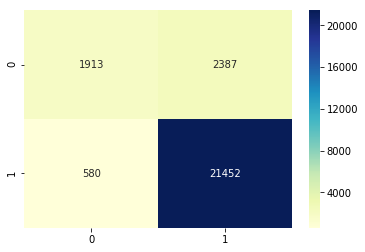

In [174]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_test.round())
sns.heatmap(cm, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
fpr2, tpr2, thresholds = roc_curve(y_train, pred_train)

score_test = roc_auc_score(y_test, pred_test)
score_train = roc_auc_score(y_train, pred_train)

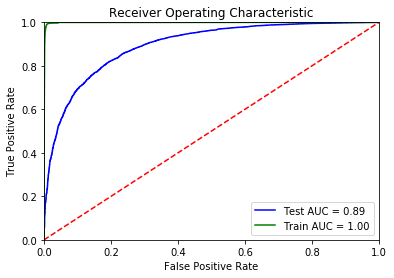

In [176]:
roc_auc_test = metrics.auc(fpr, tpr)
roc_auc_train = metrics.auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='Test AUC = %0.2f' % score_test)
plt.plot(fpr2, tpr2, 'g', label = 'Train AUC = %0.2f' % score_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### [4.4.1.2] TFIDF weighted W2v

In [180]:
    
X = list_sent[:]
y = final['Score'][:]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)

print('done')

done


In [0]:
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

tfidf_features = tf_idf_vect.get_feature_names()

train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_train:
    # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_features:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_vectors.append(sent_vec)
    row += 1

In [0]:
test_vectors = []; 

row=0;
for sent in X_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_features:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_vectors.append(sent_vec)
    row += 1

In [0]:
X_train4 = train_vectors
X_test4 = test_vectors

### Applying Random Forest Classifier

In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


grid_params = dict(n_estimators = [10,20,50,100],
                   max_depth= [6,10,15,20] )

rf = RandomForestClassifier()
rf_clf = GridSearchCV(rf, param_grid=grid_params, n_jobs=-1, verbose=30,return_train_score=True,scoring='roc_auc')
rf_clf = rf_clf.fit(X_train4, y_train)


results = rf_clf.cv_results_


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

In [185]:
print("Best parameters: ", rf_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(rf_clf.best_score_))

Best parameters:  {'max_depth': 15, 'n_estimators': 100}
Best cross-validation score: 0.870


In [0]:
pred = rf_clf.predict(X_test4)
pred_train = rf_clf.predict(X_train4)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

train_error=rf_clf.cv_results_['mean_train_score']
cv_error = rf_clf.cv_results_['mean_test_score']
score=roc_auc_score(y_train, pred_train)

estimator=rf_clf.best_params_['n_estimators']
depth=rf_clf.best_params_['max_depth']


#### Error plots

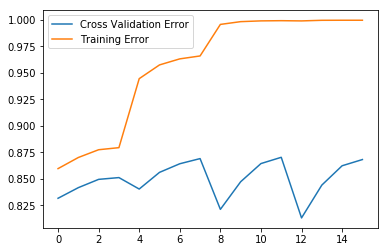

In [188]:
plt.plot(cv_error, label='Cross Validation Error')
plt.plot(train_error, label='Training Error')
plt.legend()
plt.show()

### HeatMap for AUC vs N_estimators and Max_Depth

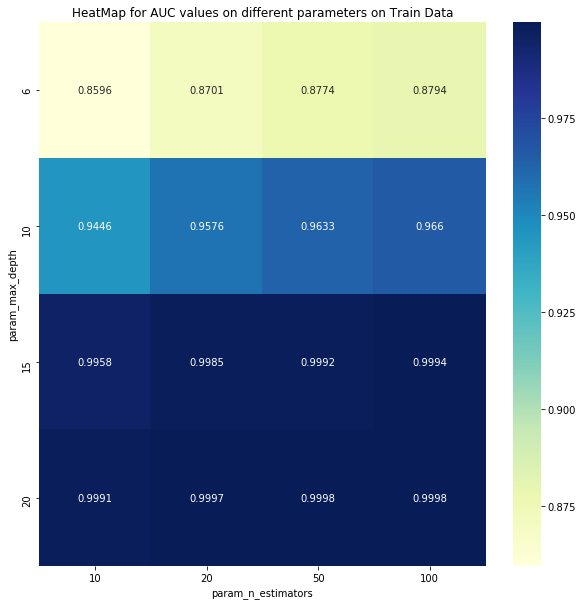

In [189]:
df_new = pd.DataFrame(rf_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_train_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Train Data')
plt.show()

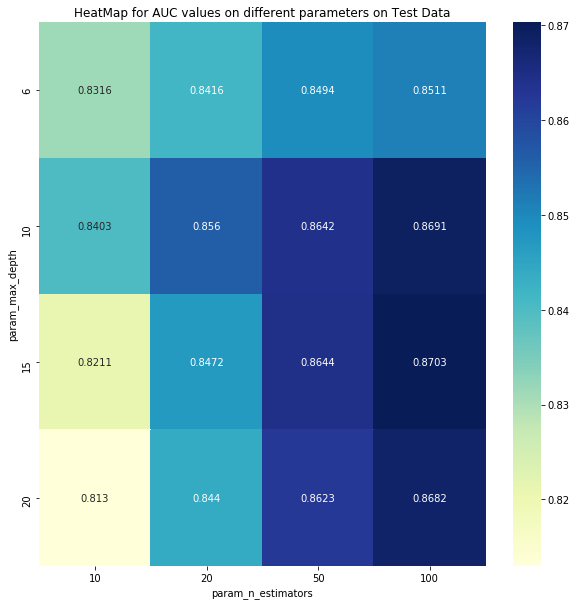

In [190]:
df_new = pd.DataFrame(rf_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_test_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Test Data')
plt.show()

In [0]:
pred_test = rf_clf.predict_proba(X_test4)[:,1]
pred_train =  rf_clf.predict_proba(X_train4)[:,1]

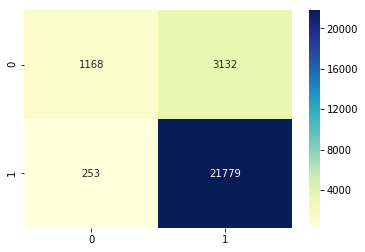

In [192]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_test.round())
sns.heatmap(cm, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
fpr2, tpr2, thresholds = roc_curve(y_train, pred_train)

score_test = roc_auc_score(y_test, pred_test)
score_train = roc_auc_score(y_train, pred_train)

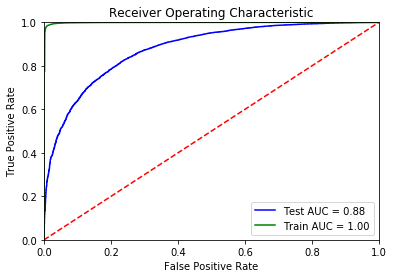

In [194]:
roc_auc_test = metrics.auc(fpr, tpr)
roc_auc_train = metrics.auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='Test AUC = %0.2f' % score_test)
plt.plot(fpr2, tpr2, 'g', label = 'Train AUC = %0.2f' % score_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Applying XGBOOST Classifier

In [195]:
from sklearn.model_selection import GridSearchCV


grid_params = {'n_estimators': [5, 10, 15,20],
              'max_depth': [2, 5, 15]}

xg_clf = xgb.XGBClassifier()
xg_clf = GridSearchCV(xg_clf, param_grid=grid_params, n_jobs=-1, verbose=30,return_train_score=True,scoring='roc_auc')
xg_clf = xg_clf.fit(np.array(X_train4), y_train)

results =xg_clf.cv_results_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    8.7s


In [196]:
print("Best parameters: ", xg_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(xg_clf.best_score_))

Best parameters:  {'max_depth': 15, 'n_estimators': 20}
Best cross-validation score: 0.861


In [0]:
pred = xg_clf.predict(X_test4)
pred_train = xg_clf.predict(X_train4)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

train_error=xg_clf.cv_results_['mean_train_score']
cv_error = xg_clf.cv_results_['mean_test_score']
score=roc_auc_score(y_train, pred_train)

estimator=xg_clf.best_params_['n_estimators']
depth=xg_clf.best_params_['max_depth']


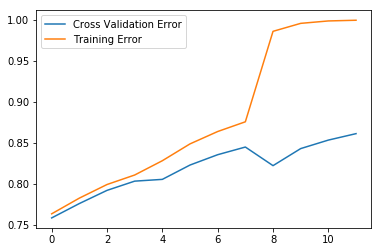

In [199]:
plt.plot(cv_error, label='Cross Validation Error')
plt.plot(train_error, label='Training Error')
plt.legend()
plt.show()

### HeatMap for AUC vs N_estimators and Max_Depth

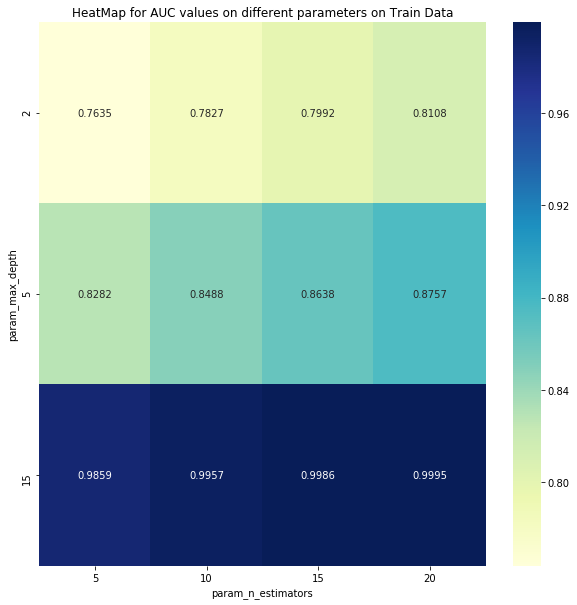

In [200]:
df_new = pd.DataFrame(xg_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_train_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Train Data')
plt.show()

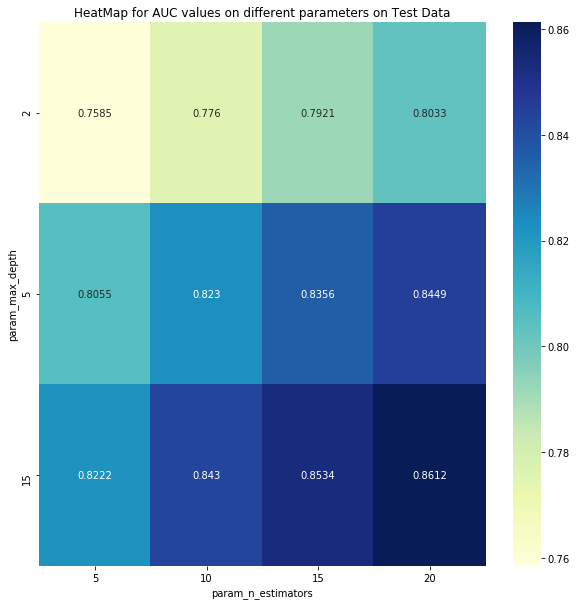

In [201]:
df_new = pd.DataFrame(xg_clf.cv_results_)
max_params = df_new.groupby(['param_max_depth','param_n_estimators']).max()
max_params = max_params.unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(max_params.mean_test_score, annot=True,cmap="YlGnBu", fmt='.4g',ax=ax)
plt.title('HeatMap for AUC values on different parameters on Test Data')
plt.show()

In [0]:
pred_test = xg_clf.predict_proba(X_test4)[:,1]
pred_train =  xg_clf.predict_proba(X_train4)[:,1]

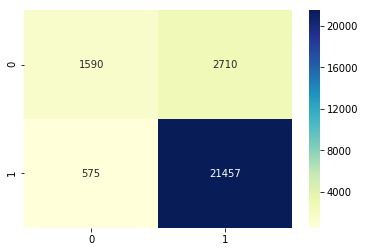

In [203]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_test.round())
sns.heatmap(cm, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
fpr2, tpr2, thresholds = roc_curve(y_train, pred_train)

score_test = roc_auc_score(y_test, pred_test)
score_train = roc_auc_score(y_train, pred_train)

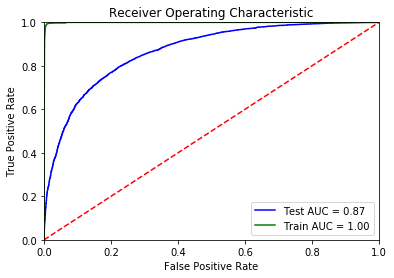

In [205]:
roc_auc_test = metrics.auc(fpr, tpr)
roc_auc_train = metrics.auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='Test AUC = %0.2f' % score_test)
plt.plot(fpr2, tpr2, 'g', label = 'Train AUC = %0.2f' % score_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

- - - 

# [5] Conclusions

In [206]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["1", "2", "Train AUC", "Test AUC"]

x.add_row(["Random Forest", "Bag-of-Words", 0.93, 0.90])
x.add_row(["XGBoost", "Bag-of-Words", 0.99, 0.94])
x.add_row(["Random Forest", "TF-IDF", 0.95, 0.92])
x.add_row(["XGBoost", "TF-IDF", 0.99, 0.94])
x.add_row(["Random Forest", "AVG-W2V", 0.97, 0.90])
x.add_row(["XGBoost", "AVG-W2V", 1.0, 0.89])
x.add_row(["Random Forest", "W2V-TFIDF", 1.0, 0.88])
x.add_row(["XGBoost", "W2V-TFIDF", 1.0, 0.87])


print(x)

+---------------+--------------+-----------+----------+
|       1       |      2       | Train AUC | Test AUC |
+---------------+--------------+-----------+----------+
| Random Forest | Bag-of-Words |    0.93   |   0.9    |
|    XGBoost    | Bag-of-Words |    0.99   |   0.94   |
| Random Forest |    TF-IDF    |    0.95   |   0.92   |
|    XGBoost    |    TF-IDF    |    0.99   |   0.94   |
| Random Forest |   AVG-W2V    |    0.97   |   0.9    |
|    XGBoost    |   AVG-W2V    |    1.0    |   0.89   |
| Random Forest |  W2V-TFIDF   |    1.0    |   0.88   |
|    XGBoost    |  W2V-TFIDF   |    1.0    |   0.87   |
+---------------+--------------+-----------+----------+
